# ETH Maxi DegenVault Backtest

##  Strategy  Idea:

Similarly to PMUDSC vaults ETH Maxi DegenVault also ims to take advantage of highly volatile nature of crypto assets which presents significant trading opportunities.

Let’s begin by outlining the high-level strategy of the vault:

Single-side deposits are accepted in ETH.
The vault supplies this ETH to the highest yielding Curve pool and LP tokens are staked on Convex (stETH/ETH - more details below).
At the end of every week, all accrued yield is harvested and converted to ETH.
The yield is bridged to Optimism and used to take a leveraged bet on crypto prices.
1 week ATM options are purchased on Lyra Finance or Perpetual Protocol.
Any trading profits at the end of the week are converted back to ETH, bridged back to mainnet and compounded into the strategy.

The current architecture allows the vault to be able to deploy the weekly yield to either Perpetual Protocol to open a perpetual future position or to Lyra to purchase an option. The dual integration to these derivative platforms allows the construction of a more adaptive and dynamic weekly derivative trading strategy. Trading returns are maximised and return stability improved by using the yield to open a trade with the derivative instrument that is best suited to the current market regime. Strategy also employs volatility regime tracking, adjusting the position if one of volatility-based triggers is activated.

The end result is boosted ETH returns achieved with the help of systematic trading strategy that aims to provide returns through all market regimes - leaving you comfy and moisturised in your lane. 

|                                	| Parameter value 	|
|--------------------------------	|-----------------	|
| __Trade frequency__            	| 7 days          	|
| __Trade leverage__             	| 10              	|
| __Absolute signal confidence__ 	| 5               	|
| __Base Pool__                 	| https://curve.fi/#/ethereum/pools/steth/swap |

## Implementation

### Imports

In [1]:
# General modules import
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime,timedelta,timezone

sns.set(palette='deep')
%matplotlib inline

In [2]:
# Brahma modules imports
import sys
sys.path.append("../../")
from modules.defibulizer.offchain_defibulizer import DeFibulizer
from modules.backtesting.option_backtest import OptionBacktest
from modules.util.data_helpers import group_historical_data
from modules.util.backtest_helpers import ts_signal_prep, get_str_date
from modules.constants.ethmaxi_const import PARAMS as pr

### Downloading the hourly data

For this backtest we gather 1year of historical data consisting of:
 * Hourly history of Deribit's Volatility Index: ETH DVOL
 * Price history data for ETH
 * 1-week at-the-money ETH implied volatility data from Deribit is procured automaticly by the backtest module


In [3]:
dt = DeFibulizer()

start_date = datetime(2021,7,30,8,tzinfo=timezone.utc)
end_date = datetime(2022,10,28,8,tzinfo=timezone.utc)

# Downloading the raw data
raw_data = dt.get_data(['ETHUSDT-PERP','ETH-DVOL'], start_date, end_date, frequency='h')
raw_data.index = pd.to_datetime(raw_data.index)

# Preprocessing only the needed columns for the backtest
hourly_prices = raw_data['ETHUSDT-PERP'][['open','high','low','close']]
hourly_dvol = raw_data['ETH-DVOL'][['open','close']].rename(columns={'open':'dvol_open','close':'dvol_close'}) / 100

# Getting the str date formats for file navigation
start_date_str = get_str_date(start_date)
end_date_str = get_str_date(end_date)

### Establishing the Hyperparameters

First we are going to set up all of the backtest hyperparameters:

In [4]:
#General Parameters

base_yield = pr['base_yield'] # Deposit yield
trade_freq = pr['trade_freq'] # Interest harvest and trade frequency (days)
is_usd = pr['is_usd'] # Whether the asset conversion is occuring in the strategy
historical_vol = pr['historical_vol'] # Whether to use historical vol provided by Deribit API

In [5]:
print(is_usd)

False


In [6]:
# Signal Parameters

short_window = pr['short_window'] 
long_window = pr['long_window']
confidence = pr['confidence']

In [7]:
# Option Parameters

option_rate = pr['option_rate']
strike_rounding = pr['strike_rounding']
otm_percentage = pr['otm_percentage'] # % OTM of strike to buy/sell
bid_offer_spread = pr['bid_offer_spread'] 

In [8]:
# Volatility Parameters

volatility_bounds = {'rv_start': pr['rv_start'], 'dvol_open': pr['dvol_open'],
                     'sigma_open': pr['sigma_open'], 'dvol_premium': pr['dvol_premium']}

Next we will construct a TS position signal based on the given hyperparameters

In [9]:
tr_scan_labels_short = pd.read_csv(f'ts_data/ts_{short_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')
tr_scan_labels_long = pd.read_csv(f'ts_data/ts_{long_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')

In [10]:
positions = ts_signal_prep(tr_scan_labels_short, tr_scan_labels_long, confidence)

### Running The Backtest

In [11]:
backtest = OptionBacktest(price_data=hourly_prices, 
                          position_data=positions, rate=base_yield,
                          option_rate=option_rate, bid_offer_spread=bid_offer_spread,
                          trade_freq=trade_freq, strike_otm=0, 
                          volatility_bounds=volatility_bounds,
                          strike_rounding=strike_rounding, is_usd=is_usd,
                          dvol_data=hourly_dvol, historical_vol=historical_vol)

Backtest results record every valuable parameter for further reseach during each epoch.

In [12]:
backtest.backtest_results.tail(1)

,position_open_time,position_close_time,open,close,high,low,position,rv_start,rv_end,dvol_open,...,put_payoff,option_price,option_payoff,position_return,vault_balance_start,vault_balance_end,invested_yield,trade_profit,benchmark,transaction_fee
time,,,,,,,,,,,,,,,,,,,,,
2022-10-28 08:00:00+00:00,2022-10-21 08:00:00+00:00,2022-10-28 08:00:00+00:00,1284.16,1493.22,1595.0,1248.0,-1,0.386714,0.71093,0.7567,...,0.0,0.035925,0.0,-1.0,1.104083,1.104083,0.001165,-0.001165,1.0698,0.0


### Backtest Metrics

Strategy metrics:

In [13]:
backtest.strategy_metrics

,0
Strategy Yield,10.408256
Strategy APY,8.456708
Benchmark APY,5.671211
Trading Boost,1.491164
Sharpe Ratio,4.698237
Max Drawdown,0.000000


Signal metrics:

In [14]:
backtest.signal_metrics

,0
Epochs,65.000000
% Trades,0.738462
% Longs,0.562500
% Shorts,0.437500
Trade Hit Rate %,0.437500
Signal Hit Rate %,0.604167


### __Backtest Performance Visualisation__

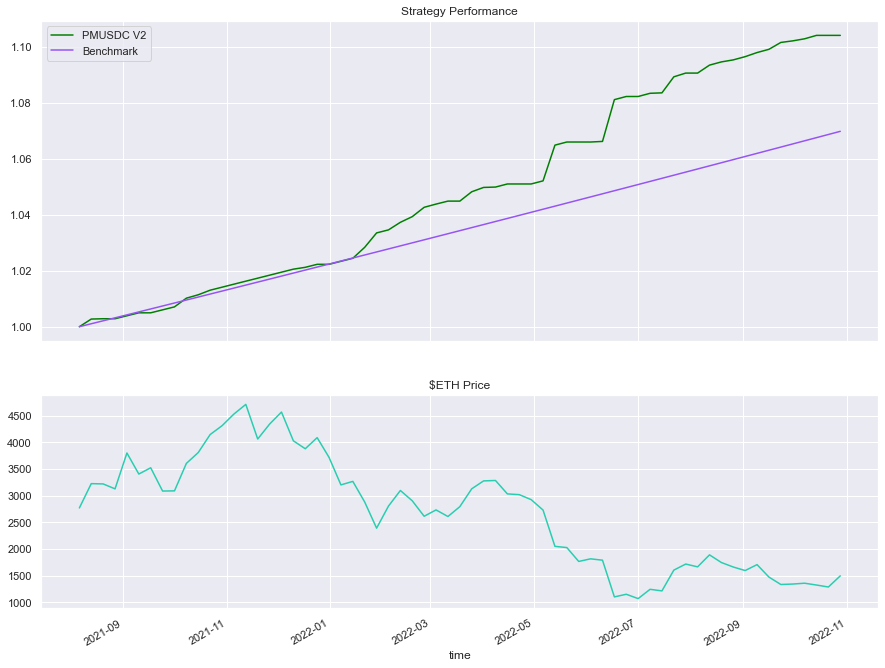

In [15]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}, sharex=True);

backtest.backtest_results.vault_balance_end.plot(figsize = (15,12), ax=axs[0], title='Strategy Performance', legend = True, color='green');
backtest.backtest_results.benchmark.plot(figsize = (15,12), ax=axs[0], legend = True, color='#9654F4');
axs[0].legend(['PMUSDC V2', 'Benchmark']);
backtest.backtest_results.close.plot(ax=axs[1], title='$ETH Price', legend=False, color='#27CEAF');

### Volatility analysis plot

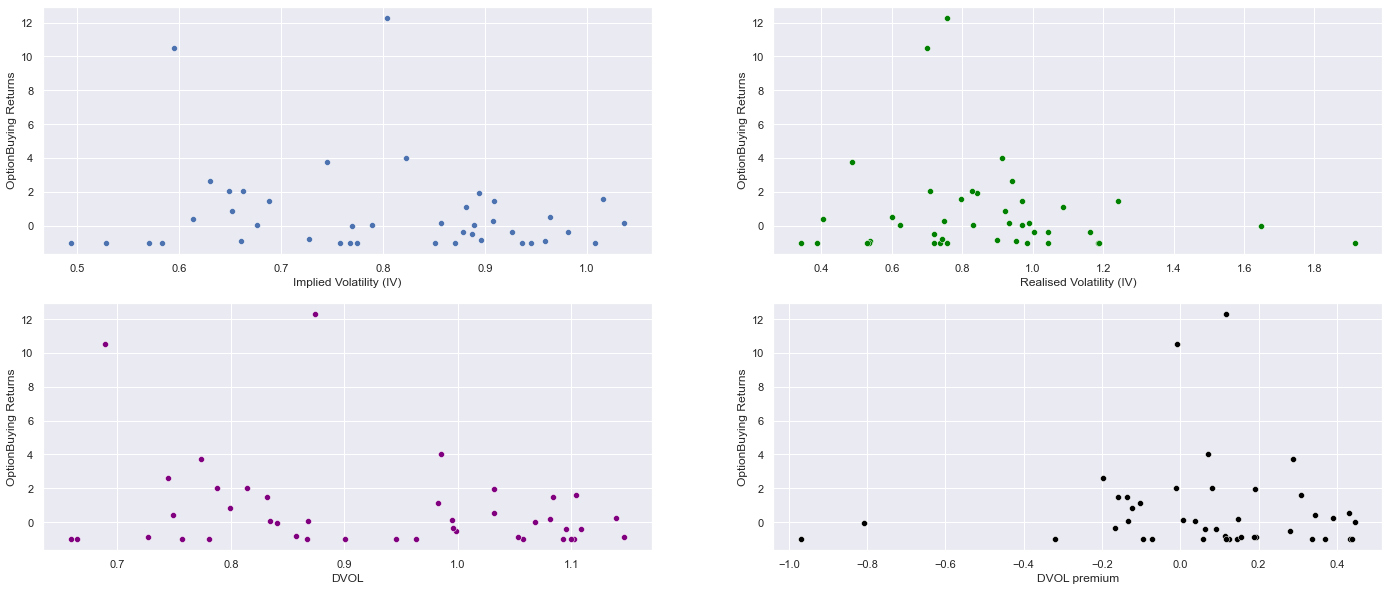

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))

# Plotting the absolute price move against the option buying strategy returns
# sns.scatterplot(x=abs(weekly_data.price_change), y=lyra_eth.optionReturns, ax=axes[0,0]);
# axes[0,0].set_xlabel('Abs Price Move');
# axes[0,0].set_ylabel('OptionBuying Returns');
sns.scatterplot(x=backtest.backtest_results.sigma_open, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[0,0]);
axes[0,0].set_xlabel('Implied Volatility (IV)');
axes[0,0].set_ylabel('OptionBuying Returns');


# Plotting the Implied Volatility (IV) against the option buying strategy returns
sns.scatterplot(x=backtest.backtest_results.rv_start, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[0,1], color="green");
axes[0,1].set_xlabel('Realised Volatility (IV)');
axes[0,1].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the option buying strategy returns
sns.scatterplot(x=backtest.backtest_results.dvol_open, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[1,0], color="purple");
axes[1,0].set_xlabel('DVOL');
axes[1,0].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the enhanced perp strategy returns
sns.scatterplot(x=backtest.backtest_results.dvol_premium, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[1,1], color="black");
axes[1,1].set_xlabel('DVOL premium');
axes[1,1].set_ylabel('OptionBuying Returns');